## Importing Libraries and Dataset

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import h5py
import time

# Retrieve a class of functions for splitting the data
from sklearn.model_selection import train_test_split

# Principal Component Analysis
from sklearn.decomposition import PCA

# Assessing performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

np.random.seed(42)

## Inspecting the Dataset

In [2]:
fid = h5py.File("dataset_patchcamelyon.h5", "r")
X, y = fid["X"][:]/255., fid["Y"][:].flatten()
fid.close()

In [3]:
def plot_image(data):
    arr = np.squeeze(data)
    plt.imshow(arr)
    plt.show()

In [4]:
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.squeeze(instance) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Let"s look at images that contain no metastases (`Y=0`)

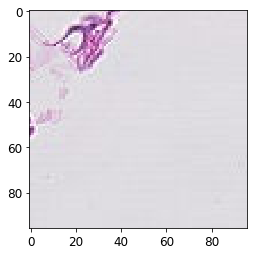

In [5]:
plot_image(X[y == 0][0])

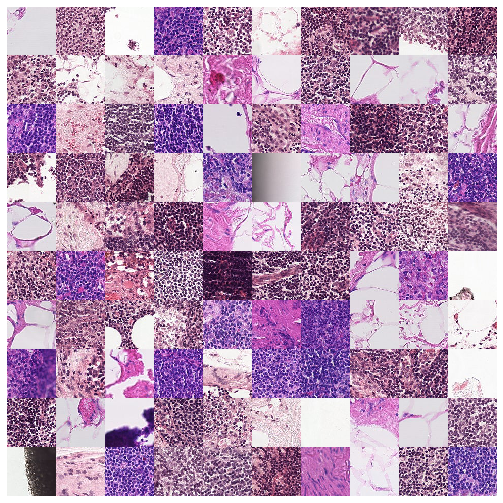

In [6]:
plt.figure(figsize=(9,9))
X_0 = X[y == 0]
example_images = X_0[:100]
plot_images(example_images, images_per_row=10)

Let"s look at images that contains metastases (`Y=1`)

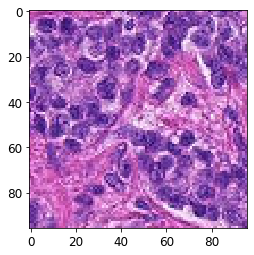

In [7]:
plot_image(X[y == 1][0])

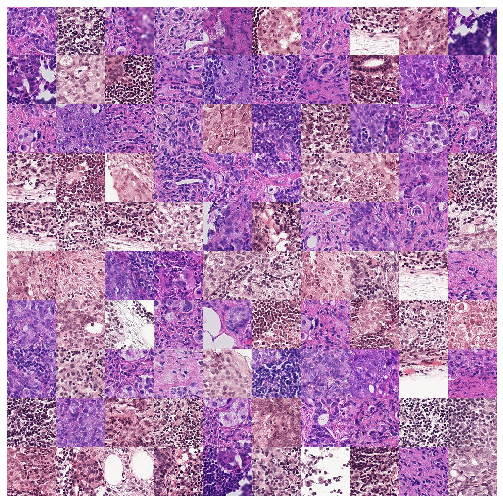

In [8]:
plt.figure(figsize=(9,9))
X_1 = X[y == 1]
example_images = X_1[:100]
plot_images(example_images, images_per_row=10)

## Supervised Learning Methods

Here we fine-tune supervised learning algorithms in terms of f1-score (a custom scorer) in order to find the best algorithm that minimizes false negatives while still maintaining good precision. Since we are building a system to predict a condition, we want to capture the condition even if we are not very sure. 

Since the following models run on CPU instead of a GPU, it is a good idea to reduce the dimensionality of the data with PCA before optimizing the models. This will save us a lot of time and may even improve the results.

In [9]:
f1 = make_scorer(f1_score , average='macro')

### PCA Dimensionality Reduction with 95% Preserved

The dataset we are passing in is a 4d array; we need to reshape the array into a 2d array. First dimension is maintained and the other three dimensions are flattened (so 94x94x3 becomes 27648). The fit algorithm will look at (2500, 27648) and extract the principal components. The number of principal components is equal to the smallest dimension of the matrix. Here, it will be the number of rows, so we consider the first 2500 features part of sample number one and the next 2500 features part of sample two and so on. 

In [10]:
X.shape

(2500, 96, 96, 3)

In [11]:
nsamples, nx, ny, nz = X.shape
X = X.reshape((nsamples, nx*ny*nz))

In [12]:
X.shape

(2500, 27648)

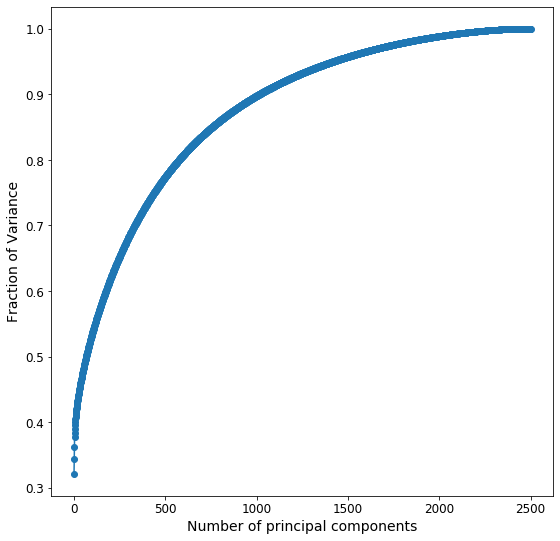

1418 components of the total 2500 components account for 95% of variance


In [13]:
# create the principal components of the training data
pcaval = PCA()
pcaval.fit(X)

# compute how much variance is explained by each component
CUMSUM = np.cumsum(pcaval.explained_variance_ratio_)

plt.figure(figsize=(9,9))
plt.plot(range(1,2501), CUMSUM, marker="o")
plt.xlabel("Number of principal components")
plt.ylabel("Fraction of Variance")
plt.show()

# print out how many components explain at least 95% of the variance
dmax = np.argmax(CUMSUM >= 0.95) + 1
print(dmax, "components of the total", pcaval.explained_variance_ratio_.size, "components account for 95% of variance")

In [14]:
# Perform a principal component decomposition and keep the first "dmax" components
t1 = time.time()
pcaval = PCA(n_components = dmax)
X_pca = pcaval.fit_transform(X)
t2 = time.time()
print("X_pca:", X_pca.shape, "\t computational time =", t2-t1, "s")

X_pca: (2500, 1418) 	 computational time = 38.51831603050232 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'First Dmax components')

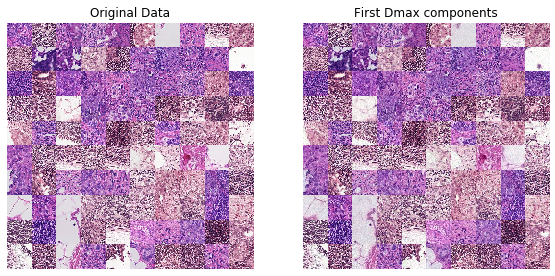

In [15]:
X_pca_reconstructed = pcaval.inverse_transform(X_pca)

images0 = []
images1 = []
for k in range(0,10):         # loop across rows...
    row_images0 = []
    row_images1 = []
    for j in range(0,10):     # loop across columns...
        tmp = X[10*k+j,:].reshape(96, 96, 3)
        row_images0.append(tmp)
        
        tmp = X_pca_reconstructed[10*k+j,:].reshape(96, 96, 3)
        row_images1.append(tmp)

    tmp = np.concatenate(row_images0, axis=1)
    images0.append(tmp)
    tmp = np.concatenate(row_images1, axis=1)
    images1.append(tmp)

images0 = np.concatenate(images0, axis=0)
images1 = np.concatenate(images1, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(images0, cmap = mpl.cm.binary)
plt.axis("off")
plt.title("Original Data")

plt.subplot(132)
plt.imshow(images1, cmap = mpl.cm.binary)
plt.axis("off")
plt.title("First Dmax components")

### Split the Dataset

In [16]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Function to get each classifiers choosen metrics.

In [17]:
def get_info(clf):    
    y_score = cross_val_predict(clf, X_train_pca, y_train, cv=3, method="predict_proba")

    # hack to work around issue #9589 in Scikit-Learn 0.19.0
    if y_score.ndim == 2:
        y_score = y_score[:, 1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_score)

    # Plot ROC curves
    plt.subplots(1, figsize=(8.2,5.5))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

    # Precision v. Recall    
    P0, R0, T0 = precision_recall_curve(y_train, y_score)
    plt.figure(1, figsize=(18, 12))
    plt.clf()
    plt.subplot(224)
    plt.plot(R0, P0, "b-", linewidth=3)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()

    # Report the ROC AUC score
    print("\nROC AUC Score for", clf.__class__.__name__, ":", roc_auc_score(y_train, y_score), "\n")

### SVM Classifier

In [18]:
kernel = ["poly", "rbf", "sigmoid"]
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ["scale"]

grid = dict(kernel=kernel, C=C, gamma=gamma)

grid_search = GridSearchCV(SVC(probability=True), param_grid=grid, n_jobs=-1, cv=3, verbose=2, scoring=f1)
grid_search.fit(X_train_pca, y_train)

print("Parameters: %s with a f1-score of %f" % (grid_search.best_params_, grid_search.best_score_))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:  2.3min remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.4min finished


Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'} with a f1-score of 0.773115


In [19]:
svm_clf = grid_search.best_estimator_

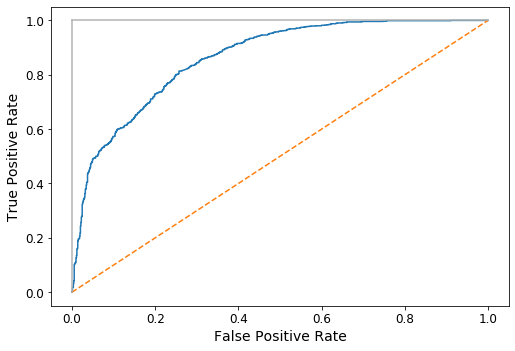

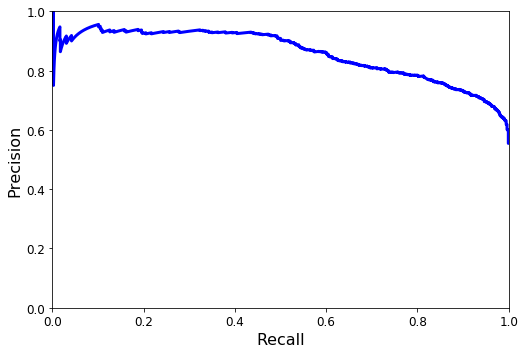


ROC AUC Score for SVC : 0.8622728609852505 



In [20]:
get_info(svm_clf)

### Random Forest Classifier

In [21]:
n_estimators = [10, 100, 500, 1000]
max_features = ["sqrt", "log2"]

grid = dict(n_estimators=n_estimators, max_features=max_features)

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid, n_jobs=-1, cv=3, verbose=2, scoring=f1)
grid_search.fit(X_train_pca, y_train)

print("Parameters: %s with a f1-score of %f" % (grid_search.best_params_, grid_search.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   13.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   24.5s finished


Parameters: {'max_features': 'sqrt', 'n_estimators': 100} with a f1-score of 0.730801


In [22]:
rnd_clf = grid_search.best_estimator_

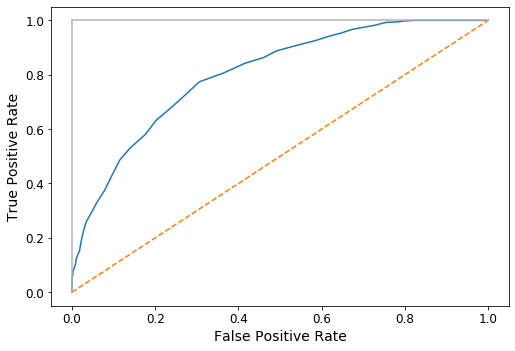

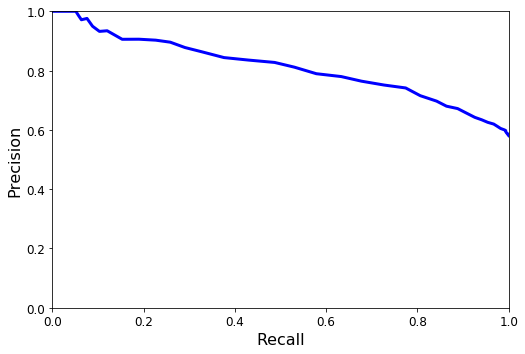


ROC AUC Score for RandomForestClassifier : 0.8035608329459626 



In [23]:
get_info(rnd_clf)

### K-Nearest Neighbors (KNN)

In [24]:
n_neighbors = range(1, 21, 2)
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan", "minkowski"]

grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=grid, n_jobs=-1, cv=3, verbose=2, scoring=f1)
grid_search.fit(X_train_pca, y_train)

print("Parameters: %s with a f1-score of %f" % (grid_search.best_params_, grid_search.best_score_))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.0min finished


Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'} with a f1-score of 0.724365


In [25]:
knn_clf = grid_search.best_estimator_

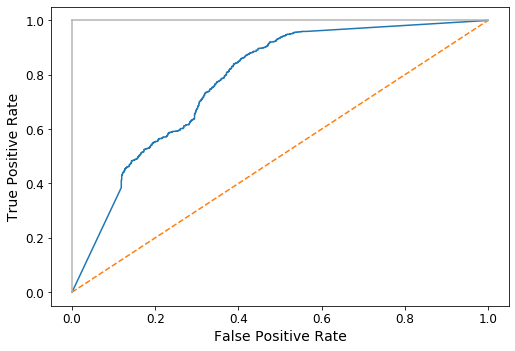

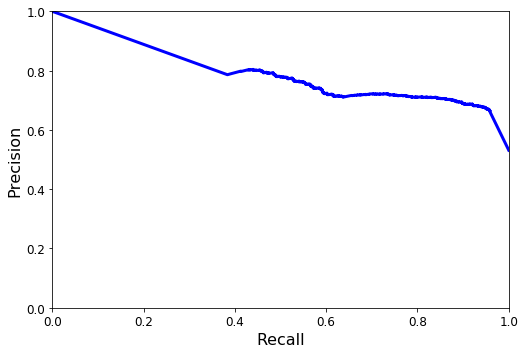


ROC AUC Score for KNeighborsClassifier : 0.7776133473757344 



In [26]:
get_info(knn_clf)

### Soft-Voting Classifier

In [27]:
classifiers = [("svm", svm_clf),
               ("rnd", rnd_clf),
               ("knn", knn_clf)]

In [28]:
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]

In [29]:
grid = dict(weights=combinations_on_off(len(classifiers)))

grid_search = GridSearchCV(VotingClassifier(classifiers, voting="soft"), param_grid=grid, n_jobs=-1, cv=3, verbose=2, scoring=f1)
grid_search.fit(X_train_pca, y_train)

print("Parameters: %s with a f1-score of %f" % (grid_search.best_params_, grid_search.best_score_))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:   53.6s remaining:   40.2s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.1min finished


Parameters: {'weights': [1, 0, 0]} with a f1-score of 0.774806


We tried every combination of `SVM`, `RF`, and `KNN` but the highest f1-score could only be achieved by `SVM` alone. As such, we will not evaluate the soft-voting classifier on the testing data. 

## Evaluate the Classifiers on Test Data

### SVM Classifier

In [39]:
y_pred = svm_clf.predict(X_test_pca)

print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report")
target_names = ["No metastases", "Metastases"]
print(classification_report(y_test, y_pred, target_names=target_names))


Confusion Matrix
 [[180  67]
 [ 33 220]]

Classification Report
               precision    recall  f1-score   support

No metastases       0.85      0.73      0.78       247
   Metastases       0.77      0.87      0.81       253

     accuracy                           0.80       500
    macro avg       0.81      0.80      0.80       500
 weighted avg       0.81      0.80      0.80       500



### Random Forest Classifier

In [33]:
y_pred = rnd_clf.predict(X_test_pca)

print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report")
target_names = ["No metastases", "Metastases"]
print(classification_report(y_test, y_pred, target_names=target_names))


Confusion Matrix
 [[152  95]
 [ 33 220]]

Classification Report
               precision    recall  f1-score   support

No metastases       0.82      0.62      0.70       247
   Metastases       0.70      0.87      0.77       253

     accuracy                           0.74       500
    macro avg       0.76      0.74      0.74       500
 weighted avg       0.76      0.74      0.74       500



### K-Nearest Neighbors (KNN) Classifer

In [34]:
y_pred = knn_clf.predict(X_test_pca)

print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report")
target_names = ["No metastases", "Metastases"]
print(classification_report(y_test, y_pred, target_names=target_names))


Confusion Matrix
 [[149  98]
 [ 36 217]]

Classification Report
               precision    recall  f1-score   support

No metastases       0.81      0.60      0.69       247
   Metastases       0.69      0.86      0.76       253

     accuracy                           0.73       500
    macro avg       0.75      0.73      0.73       500
 weighted avg       0.75      0.73      0.73       500



`SVM` proves to be the best model in terms of precision, recall, and f1-score.  